# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Prevent incompatible gpu

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-07-23 01:05:45.626614: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 01:05:46.012438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753203946.169147  337366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753203946.218477  337366 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753203946.587837  337366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 7004 files belonging to 3 classes.
Found 859 files belonging to 3 classes.
Found 860 files belonging to 3 classes.


2025-07-23 01:05:50.920734: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


,broccoli,cauliflower,unknown,splits total
test,311,299,250,860
train,2595,2407,2002,7004
validate,311,298,250,859
img total,3217,3004,2502,8723


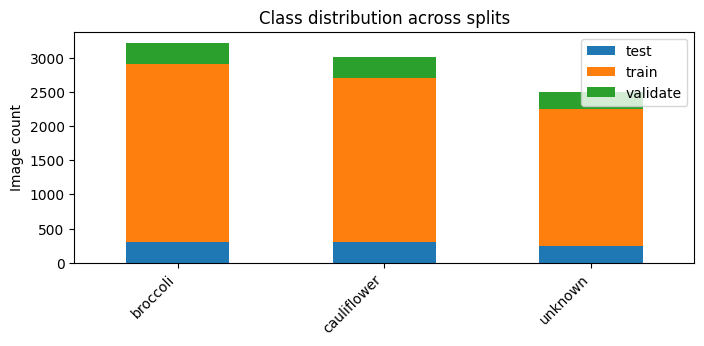

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

2025-07-23 01:05:52.271821: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


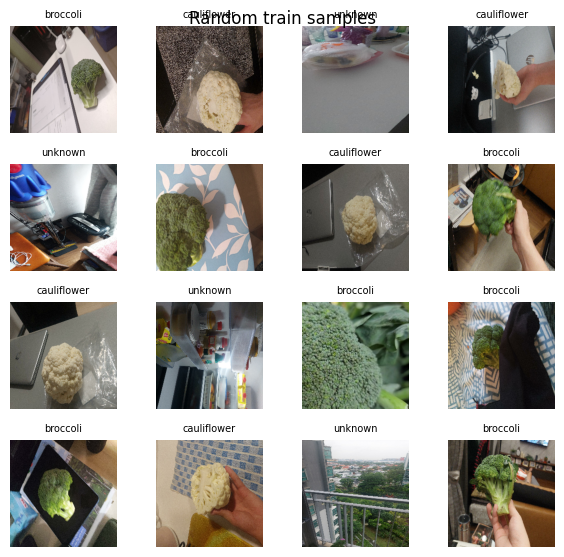

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom((0.3), 0.3),
    layers.RandomBrightness(0.2, value_range=(0, 1)),
    layers.RandomErasing(0.3, value_range=(0, 1))
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

2025-07-23 01:06:03.595211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 14 of 1000
2025-07-23 01:06:23.039785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-07-23 01:06:29.493152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:06:30.393012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-23 01:06:30.393124: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already c

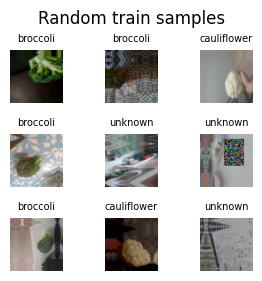

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))

model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 50→25
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))

model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 12→6
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 12→6
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Optimizer = optimizers.AdamW(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,763 (6.13 MB)

 Trainable params: 1,605,763 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(
    train_ds,
    epochs=100,
    verbose=1,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights("model.weights.h5")
model.save("model.hdf5")

Epoch 1/100


2025-07-23 01:06:42.242803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:06:48.888946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:06:49.865835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3582 - loss: 1.0958

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.3584 - loss: 1.0956 - val_accuracy: 0.3620 - val_loss: 1.0842
Epoch 2/100


2025-07-23 01:09:01.547935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:09:08.517811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4490 - loss: 1.0442

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4509 - loss: 1.0431 - val_accuracy: 0.6531 - val_loss: 0.9339
Epoch 3/100


2025-07-23 01:11:20.035198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:11:27.906019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6447 - loss: 0.9031

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.6457 - loss: 0.9016 - val_accuracy: 0.7509 - val_loss: 0.7723
Epoch 4/100


2025-07-23 01:13:58.191109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 15 of 1000
2025-07-23 01:14:06.222544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7434 - loss: 0.7268

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.7437 - loss: 0.7254 - val_accuracy: 0.8196 - val_loss: 0.5225
Epoch 5/100


2025-07-23 01:16:29.909041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 10 of 1000
2025-07-23 01:16:40.098836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 19 of 1000
2025-07-23 01:16:49.721614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:16:50.765137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7813 - loss: 0.6104

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.7812 - loss: 0.6103 - val_accuracy: 0.7241 - val_loss: 0.6929
Epoch 6/100


2025-07-23 01:19:09.797395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:19:17.165411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:19:18.170004: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7713 - loss: 0.6043

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.7715 - loss: 0.6040 - val_accuracy: 0.8347 - val_loss: 0.4674
Epoch 7/100


2025-07-23 01:21:47.489172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:21:54.377654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7868 - loss: 0.5666

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.7866 - loss: 0.5667 - val_accuracy: 0.8044 - val_loss: 0.4932
Epoch 8/100


2025-07-23 01:24:05.468957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:24:12.245426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:24:13.266661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7893 - loss: 0.5466

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 01:26:08.598115: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.7898 - loss: 0.5458 - val_accuracy: 0.8242 - val_loss: 0.4587
Epoch 9/100


2025-07-23 01:26:23.060962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:26:29.885658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8114 - loss: 0.5082

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8113 - loss: 0.5078 - val_accuracy: 0.8650 - val_loss: 0.3773
Epoch 10/100


2025-07-23 01:28:41.721709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:28:48.022365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:28:49.039733: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8253 - loss: 0.4723

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.8252 - loss: 0.4723 - val_accuracy: 0.8172 - val_loss: 0.4683
Epoch 11/100


2025-07-23 01:31:05.924204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 15 of 1000
2025-07-23 01:31:13.336088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:31:14.277951: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8093 - loss: 0.5101

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8097 - loss: 0.5087 - val_accuracy: 0.8766 - val_loss: 0.3280
Epoch 12/100


2025-07-23 01:33:25.177958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:33:31.329987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:33:32.279662: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8532 - loss: 0.4018

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 01:35:27.706087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8530 - loss: 0.4025 - val_accuracy: 0.8754 - val_loss: 0.3046
Epoch 13/100


2025-07-23 01:35:42.545509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:35:49.933419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:35:50.898932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8453 - loss: 0.3986

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 01:37:46.833196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8455 - loss: 0.3982 - val_accuracy: 0.8789 - val_loss: 0.3294
Epoch 14/100


2025-07-23 01:38:01.727537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:38:09.086324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:38:09.974253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8711 - loss: 0.3455

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8712 - loss: 0.3452 - val_accuracy: 0.8731 - val_loss: 0.3246
Epoch 15/100


2025-07-23 01:40:20.946242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:40:27.591944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8576 - loss: 0.3750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 01:42:24.998056: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8577 - loss: 0.3747 - val_accuracy: 0.8522 - val_loss: 0.3579
Epoch 16/100


2025-07-23 01:42:39.983712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:42:47.212635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:42:48.136926: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8683 - loss: 0.3478

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8686 - loss: 0.3472 - val_accuracy: 0.9104 - val_loss: 0.2487
Epoch 17/100


2025-07-23 01:44:59.196600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:45:05.517617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:45:06.456785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8777 - loss: 0.3331

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8778 - loss: 0.3328 - val_accuracy: 0.9220 - val_loss: 0.2403
Epoch 18/100


2025-07-23 01:47:17.223906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:47:23.223805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8885 - loss: 0.2998

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.8884 - loss: 0.3001 - val_accuracy: 0.8126 - val_loss: 0.4694
Epoch 19/100


2025-07-23 01:49:33.138866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:49:39.109167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:49:40.036651: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8542 - loss: 0.3824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.8546 - loss: 0.3814 - val_accuracy: 0.9208 - val_loss: 0.2202
Epoch 20/100


2025-07-23 01:51:49.805379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:51:55.857717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:51:56.747576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8925 - loss: 0.2960

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.8923 - loss: 0.2963 - val_accuracy: 0.9104 - val_loss: 0.2445
Epoch 21/100


2025-07-23 01:54:06.283923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:54:12.253259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:54:13.224352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9015 - loss: 0.2667

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 01:56:08.206091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9014 - loss: 0.2670 - val_accuracy: 0.9115 - val_loss: 0.2395
Epoch 22/100


2025-07-23 01:56:23.070276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 01:56:30.307389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:56:31.185834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8856 - loss: 0.2970

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8854 - loss: 0.2973 - val_accuracy: 0.9092 - val_loss: 0.2591
Epoch 23/100


2025-07-23 01:58:40.924132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 01:58:46.956092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 01:58:47.774088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9037 - loss: 0.2684

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9036 - loss: 0.2684 - val_accuracy: 0.9523 - val_loss: 0.1701
Epoch 24/100


2025-07-23 02:00:57.013007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:01:03.070185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:01:03.989902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9040 - loss: 0.2733

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 02:02:58.598886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9039 - loss: 0.2735 - val_accuracy: 0.8882 - val_loss: 0.2836
Epoch 25/100


2025-07-23 02:03:13.333207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 02:03:20.710475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:03:21.615890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9121 - loss: 0.2499

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9121 - loss: 0.2496 - val_accuracy: 0.9022 - val_loss: 0.2581
Epoch 26/100


2025-07-23 02:05:30.576164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 02:05:37.690299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:05:38.656186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9044 - loss: 0.2613

Invalid SOS parameters for sequential JPEG
2025-07-23 02:07:32.984720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9042 - loss: 0.2616 - val_accuracy: 0.9499 - val_loss: 0.1709
Epoch 27/100


2025-07-23 02:07:47.599424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 02:07:54.912192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:07:55.783494: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9130 - loss: 0.2330

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.9131 - loss: 0.2329 - val_accuracy: 0.9383 - val_loss: 0.1807
Epoch 28/100


2025-07-23 02:10:00.513652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:10:06.456580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9258 - loss: 0.2182

Invalid SOS parameters for sequential JPEG
2025-07-23 02:11:57.790104: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.9257 - loss: 0.2183 - val_accuracy: 0.9558 - val_loss: 0.1386
Epoch 29/100


2025-07-23 02:12:12.472719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 02:12:19.710722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:12:20.598841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9288 - loss: 0.2145

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 02:14:12.095948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.9289 - loss: 0.2142 - val_accuracy: 0.9534 - val_loss: 0.1424
Epoch 30/100


2025-07-23 02:14:26.510845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:14:32.541264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:14:33.360081: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9299 - loss: 0.2111

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 02:16:33.481702: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9297 - loss: 0.2117 - val_accuracy: 0.9662 - val_loss: 0.1307
Epoch 31/100


2025-07-23 02:16:48.556032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 02:16:55.937829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:16:56.906371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9247 - loss: 0.2150

2025-07-23 02:18:51.918639: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9247 - loss: 0.2148 - val_accuracy: 0.9418 - val_loss: 0.1620
Epoch 32/100


2025-07-23 02:19:07.065572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 16 of 1000
2025-07-23 02:19:14.297958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:19:15.207047: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9289 - loss: 0.2107

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 02:21:09.761965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9289 - loss: 0.2106 - val_accuracy: 0.9139 - val_loss: 0.2180
Epoch 33/100


2025-07-23 02:21:24.698478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:21:31.398990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:21:32.251987: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9297 - loss: 0.1965

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9298 - loss: 0.1965 - val_accuracy: 0.9627 - val_loss: 0.1143
Epoch 34/100


2025-07-23 02:23:42.016935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:23:48.079679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9400 - loss: 0.1758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-23 02:25:43.388365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9400 - loss: 0.1757 - val_accuracy: 0.9558 - val_loss: 0.1276
Epoch 35/100


2025-07-23 02:25:58.076447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:26:04.243460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9348 - loss: 0.1974

Invalid SOS parameters for sequential JPEG
2025-07-23 02:27:59.898082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9348 - loss: 0.1974 - val_accuracy: 0.9523 - val_loss: 0.1213
Epoch 36/100


2025-07-23 02:28:14.878285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:28:20.904749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9325 - loss: 0.1955

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9326 - loss: 0.1953 - val_accuracy: 0.9313 - val_loss: 0.1537
Epoch 37/100


2025-07-23 02:30:31.342166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:30:37.455741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-23 02:30:38.413679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9352 - loss: 0.1828

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9352 - loss: 0.1829 - val_accuracy: 0.9721 - val_loss: 0.0907
Epoch 38/100


2025-07-23 02:32:48.573169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:32:54.687658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9344 - loss: 0.1838

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9340 - loss: 0.1848 - val_accuracy: 0.9639 - val_loss: 0.1004
Epoch 39/100


2025-07-23 02:35:04.283839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:35:10.335182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9343 - loss: 0.1886

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9342 - loss: 0.1887 - val_accuracy: 0.9581 - val_loss: 0.1311
Epoch 40/100


2025-07-23 02:37:20.401900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:37:26.409562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9288 - loss: 0.1933

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9290 - loss: 0.1928 - val_accuracy: 0.9651 - val_loss: 0.1082
Epoch 41/100


2025-07-23 02:39:36.588372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:39:42.603889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9413 - loss: 0.1628

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9414 - loss: 0.1626 - val_accuracy: 0.9395 - val_loss: 0.1495
Epoch 42/100


2025-07-23 02:41:53.268191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 17 of 1000
2025-07-23 02:41:59.340727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9382 - loss: 0.1746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9383 - loss: 0.1742 - val_accuracy: 0.9616 - val_loss: 0.0997


2025-07-23 02:44:02.120050: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test loss: 0.09930402040481567
Test accuracy: 0.9697674512863159


# Model Evalutation

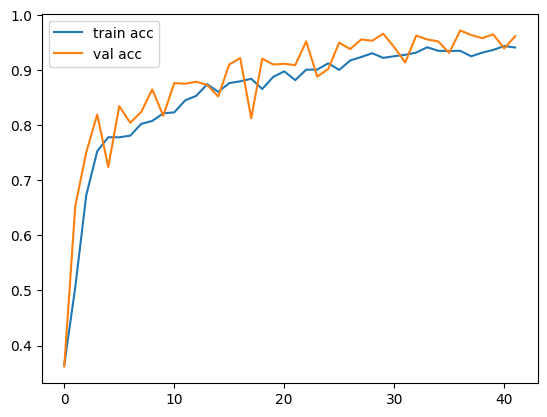

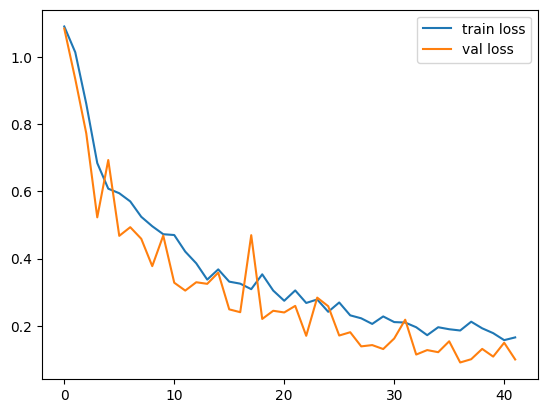

In [11]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

2025-07-23 02:44:27.051815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30723072 bytes after encountering the first element of size 30723072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
Broccoli Precision:  0.9742765273311897
Broccoli Recall :  0.9774193548387097

Cauliflower Precision:  0.9866220735785953
Cauliflower Recall:  0.9609120521172638

Unknown Precision:  0.944
Unknown Recall:  0.9711934156378601


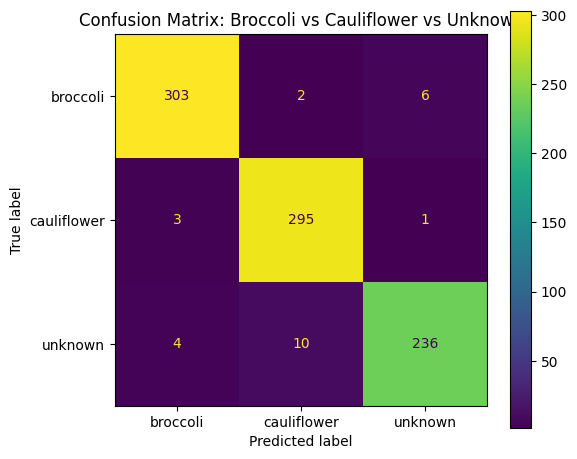

In [12]:
model = tf.keras.models.load_model('./model.hdf5')

y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = np.argmax(tf.concat([item for item in y_true], axis = 0), axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
print("Broccoli Precision: ", cm[0][0] / cm[0].sum())
print("Broccoli Recall : ", cm[0][0] / cm.T[0].sum())
print()
print("Cauliflower Precision: ", cm[1][1] / cm[1].sum())
print("Cauliflower Recall: ", cm[1][1] / cm.T[1].sum())
print()
print("Unknown Precision: ", cm[2][2] / cm[2].sum())
print("Unknown Recall: ", cm[2][2] / cm.T[2].sum())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix: Broccoli vs Cauliflower vs Unknown')
plt.tight_layout()
plt.show()